0.000%
0.000%
0.000%
6.667%
6.667%
6.667%
6.667%
6.667%
20.000%
20.000%
20.000%
20.000%
26.667%
26.667%
26.667%
26.667%
26.667%
33.333%
33.333%
40.000%
40.000%
40.000%
40.000%
40.000%
40.000%
46.667%
46.667%
46.667%
46.667%
53.333%
53.333%
60.000%
60.000%
60.000%
73.333%
73.333%
73.333%
86.667%
86.667%
86.667%


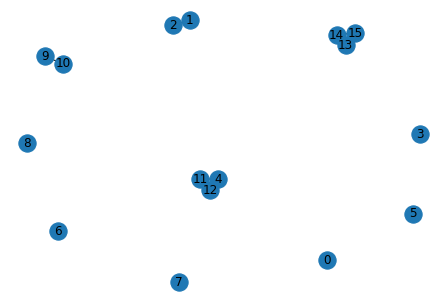

In [6]:
# libraries import
import os
import re
import json
import random
import itertools
import numpy as np
import networkx as nx
from scipy.stats import bernoulli

# fetching all the files
base_path = '/home/heaven/Documents/graph_mining/Progetto/sequences/'
files = os.listdir(base_path)

# creating the Graph using networkx
G = nx.Graph()
node_index = 0
i = 1
number_of_nodes = 15

# main loop for graph construction
for file in files:
    if node_index > number_of_nodes and not number_of_nodes == -1:
        break
    if '.json' in file:
        # opening current file
        with open(base_path + file) as in_file:
            data = json.load(in_file)
        
        if number_of_nodes == -1:
            print(str("%.3f" % (i*100/len(files))) + "%")
        else:
            print(str("%.3f" % (node_index*100/number_of_nodes)) + "%")
        i += 1
                  
        # isolating the comment section
        if 'comment' in data['results'][0]:
            comments_section = data['results'][0]['comment']

            # isolating the authors
            authors = []
            for comment in comments_section:
                pattern = '_[A-Z][\w+\s?\.?]+_'
                results = re.findall(pattern, comment)
                if results:
                    author = results[0].split('_')[1]
                    authors.append(author)
                        
            # adding the nodes
            for author in authors:
                if author not in nx.get_node_attributes(G, 'name').values():
                    G.add_node(node_index, name = author)
                    node_index += 1

            # adding the edges
            for pair in itertools.combinations(authors, 2):
                # fetching node 1
                node_1_key = list(nx.get_node_attributes(G, 'name').values()).index(pair[0])
                # fetching node 2
                node_2_key = list(nx.get_node_attributes(G, 'name').values()).index(pair[1])
                # adding the edge if it isn't already in the graph
                if (node_1_key, node_2_key) not in list(G.edges):
                    G.add_edge(node_1_key, node_2_key)

nx.draw(G, with_labels = True)

Greedy algorithm O(m) for finding a MIS

In [2]:
def greedy_MIS(G):
    V_set = list(G.nodes).copy()
    maximal_independent_set = []
    while len(V_set) > 0:
        node = random.choice(V_set)
        maximal_independent_set.append(node)
        V_set.remove(node)
        for adj_node in list(G.adj[node]):
            if adj_node in V_set:
                V_set.remove(adj_node)
    return maximal_independent_set

In [34]:
%%time
greedy_MIS(G)

CPU times: user 190 µs, sys: 0 ns, total: 190 µs
Wall time: 196 µs


[5, 39, 11, 16, 29, 23, 0, 10, 6, 34, 1, 8, 15, 33, 3]

Greedy algorithm O(m) for finding a MIS with the specified nodes in it

In [13]:
# function that returns a MIS with the specified nodes in it
def greedy_MIS_with_nodes_specified(G, chosen_nodes):
    V_set = list(G.nodes).copy()
    maximal_independent_set = []
    if check_if_set_is_IS(G, chosen_nodes):
        # inserting the chosen nodes and removing their adj list
        for node in chosen_nodes:
            maximal_independent_set.append(node)
            V_set.remove(node)
            for adj_node in list(G.adj[node]):
                if adj_node in V_set:
                    V_set.remove(adj_node)
        # main loop
        while len(V_set) > 0:
            node = random.choice(V_set)
            maximal_independent_set.append(node)
            V_set.remove(node)
            for adj_node in list(G.adj[node]):
                if adj_node in V_set:
                    V_set.remove(adj_node)
    return maximal_independent_set

Luby's algorithm O(logn) for finding a MIS

In [11]:
def luby_MIS(G):
    V_set = set(G.nodes).copy()
    E_set = list(G.edges).copy()
    maximal_independent_set = []
    while len(V_set) > 0:
        probability_dist = [1/(2*G.degree[node]) if G.degree[node] > 0 else 1 for node in V_set]
        marks = bernoulli.rvs(probability_dist, size = len(V_set))
        marked_nodes = dict(zip(V_set, marks))
        for edge in E_set:
            if edge[0] in marked_nodes and edge[1] in marked_nodes:
                if marked_nodes[edge[0]] == 1 and marked_nodes[edge[1]] == 1:
                    if G.degree[edge[0]] < G.degree[edge[1]]:
                        marked_nodes[edge[0]] = 0
                    elif G.degree[edge[0]] > G.degree[edge[1]]:
                        marked_nodes[edge[1]] = 0
                    else:
                        if edge[0] < edge[1]:
                            marked_nodes[edge[0]] = 0
                        else:
                            marked_nodes[edge[1]] = 0
        for node in V_set:
            if marked_nodes[node] == 1:
                maximal_independent_set.append(node)
        for node in maximal_independent_set:
            if node in V_set:
                V_set.remove(node)
            V_set = V_set.difference(set(G.adj[node]))
        for edge in E_set:
            if not(edge[0] in V_set and edge[1] in V_set):
                E_set.remove(edge)
    return maximal_independent_set

In [184]:
%%time
luby_MIS(Gp)

CPU times: user 1.64 ms, sys: 29 µs, total: 1.67 ms
Wall time: 1.47 ms


[4, 7, 8, 1]

Naive algorithm designed to find all MISs

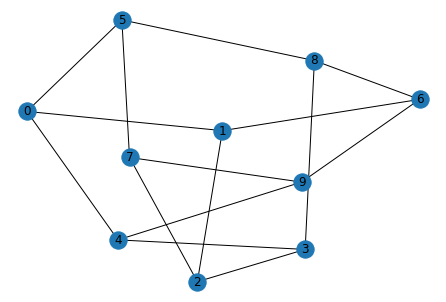

In [7]:
Gp = nx.petersen_graph()
nx.draw(Gp, with_labels = True)

In [4]:
# function that returns true if the independent set is maximal (non-extendible)
def check_if_set_is_MIS(G, IS):
    nodes_without_IS = [node for node in list(G.nodes) if node not in IS]
    if any(is_node_addable_to_IS(G, IS, node) for node in nodes_without_IS):
        return False
    else:
        return True

In [3]:
# function that returns true if the node we're trying to add doesn't turn the set into
# a dependent set
def is_node_addable_to_IS(G, IS, new_node):
    if any(new_node in G.adj[node] for node in IS):
        return False
    else:
        return True

In [2]:
def find_all_MIS_rec(G, node, V_set, remaining_nodes, set_of_found_MIS):
    if set(remaining_nodes) == set():
        return
    V_set.append(node)
    remaining_nodes.remove(node)
    for adj_node in G.adj[node]:
        if adj_node in remaining_nodes:
            remaining_nodes.remove(adj_node)
    if check_if_set_is_MIS(G, V_set):
        new_MIS = V_set.copy()
        if set(new_MIS) not in [set(MIS) for MIS in set_of_found_MIS]:
            set_of_found_MIS.append(new_MIS)
        V_set.remove(node)
    if set(V_set + remaining_nodes) not in [set(MIS) for MIS in set_of_found_MIS]:
        for rem_node in remaining_nodes:
            #if is_node_addable_to_IS(G, V_set, rem_node):
            find_all_MIS_rec(G, rem_node, V_set.copy(), remaining_nodes.copy(), set_of_found_MIS)

In [1]:
def find_all_MIS(G, mode):
    set_of_found_MIS = []
    V_set = []
    remaining_nodes = list(G.nodes).copy()
    for node in remaining_nodes:
        if G.degree[node] == 0:
            V_set.append(node)
    for node in V_set:
        remaining_nodes.remove(node)
    for node in remaining_nodes:
        #if is_node_addable_to_IS(G, V_set, node):
            find_all_MIS_rec(G, node, V_set.copy(), remaining_nodes.copy(), set_of_found_MIS)
    if mode == 'all':
        return set_of_found_MIS
    else:
        return max(set_of_found_MIS, key = len)

In [9]:
%%time
find_all_MIS(Gp, 'all')

CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 10.9 ms


[[0, 2, 6],
 [0, 2, 8, 9],
 [0, 3, 6, 7],
 [0, 3, 9],
 [0, 7, 8],
 [1, 3, 5, 9],
 [1, 3, 7],
 [1, 4, 5],
 [1, 4, 7, 8],
 [1, 8, 9],
 [2, 4, 5, 6],
 [2, 4, 8],
 [2, 5, 9],
 [3, 5, 6],
 [4, 6, 7]]

In [10]:
%%time
find_all_MIS(Gp, 'maximum')

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 10.5 ms


[0, 2, 8, 9]